<a href="https://colab.research.google.com/github/Praise-Atadja/African_delight/blob/main/Github_Final_Diagnosis_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import Necessary Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import drive
drive.mount('/content/drive')
import os
import warnings
warnings.filterwarnings('ignore')

Mounted at /content/drive


In [2]:
#load data
data = pd.read_csv('/content/drive/MyDrive/MISSION CAPSTONE/heart_2020_cleaned.csv')
data.head(10)


,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No
5,Yes,28.87,Yes,No,No,6.0,0.0,Yes,Female,75-79,Black,No,No,Fair,12.0,No,No,No
6,No,21.63,No,No,No,15.0,0.0,No,Female,70-74,White,No,Yes,Fair,4.0,Yes,No,Yes
7,No,31.64,Yes,No,No,5.0,0.0,Yes,Female,80 or older,White,Yes,No,Good,9.0,Yes,No,No
8,No,26.45,No,No,No,0.0,0.0,No,Female,80 or older,White,"No, borderline diabetes",No,Fair,5.0,No,Yes,No
9,No,40.69,No,No,No,0.0,0.0,Yes,Male,65-69,White,No,Yes,Good,10.0,No,No,No


In [3]:
# Sample 2000 rows from the DataFrame
data_sampled = data.sample(n=20000, random_state=42)  # Set random_state for reproducibility

# Now data_sampled contains 2000 random rows from your original data
data_sampled.shape

(20000, 18)

In [4]:
data_sampled.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
271884,No,27.63,Yes,No,No,0.0,25.0,No,Female,25-29,Hispanic,No,Yes,Very good,7.0,No,No,No
270361,No,21.95,No,No,No,0.0,20.0,No,Female,30-34,White,No,Yes,Excellent,6.0,No,No,Yes
219060,No,31.32,Yes,No,No,0.0,0.0,No,Female,40-44,White,No,Yes,Very good,6.0,Yes,No,No
24010,No,40.35,No,No,No,30.0,0.0,No,Female,65-69,White,No,No,Good,8.0,No,No,No
181930,No,35.61,Yes,No,No,30.0,30.0,Yes,Female,60-64,White,No,No,Fair,4.0,Yes,No,Yes


In [5]:
import random

# Define possible ECG classifications
ecg_classes = ['Myocardial Infarction', 'Normal Heartbeat',
               'History of Myocardial Infarction', 'Abnormal Heartbeat']

# Enhanced Diagnosis Function
def assign_diagnosis(ecg_class, heart_disease):
    if ecg_class == 'Myocardial Infarction':
        if heart_disease == 'Yes':
            return 'Acute Coronary Syndrome with High Risk of Recurrence'
        else:
            return 'Previous Myocardial Infarction; Stable Condition'
    elif ecg_class == 'History of Myocardial Infarction':
        return 'History of Myocardial Infarction; Risk of Complications' if heart_disease == 'Yes' else 'Stable Post-MI; No Current Risk'
    elif ecg_class == 'Abnormal Heartbeat':
        return 'Chronic Arrhythmia' if heart_disease == 'Yes' else 'Minor Arrhythmia; No Immediate Concern'
    else:  # Normal Heartbeat
        return 'Healthy Cardiac Status' if heart_disease == 'No' else 'Early Signs of Cardiac Risk'

# Enhanced Recommendation Function
# Enhanced Recommendation Function with default 'None' for CriticalAlert
def assign_recommendation(diagnosis):
    recommendations = {
        'Acute Coronary Syndrome with High Risk of Recurrence': {
            'Recommendation': 'Immediate referral to a cardiologist; prescribe anticoagulants and lifestyle changes.',
            'FollowUp': 'Weekly follow-up until condition stabilizes.',
            'CriticalAlert': 'High',
            'Referral': 'Yes'
        },
        'Previous Myocardial Infarction; Stable Condition': {
            'Recommendation': 'Regular cardiovascular assessment every 3 months; monitor symptoms.',
            'FollowUp': '3-month follow-up with primary care.',
            'CriticalAlert': 'Medium',
            'Referral': 'Consider cardiology if symptoms worsen'
        },
        'History of Myocardial Infarction; Risk of Complications': {
            'Recommendation': 'Lifestyle counseling and medication adherence; low-dose aspirin advised.',
            'FollowUp': 'Monthly check-ins to assess risk.',
            'CriticalAlert': 'Medium',
            'Referral': 'Yes'
        },
        'Stable Post-MI; No Current Risk': {
            'Recommendation': 'Annual cardiovascular exam; maintain healthy lifestyle.',
            'FollowUp': 'Annual check-up.',
            'CriticalAlert': 'Low',
            'Referral': 'No'
        },
        'Chronic Arrhythmia': {
            'Recommendation': 'Anti-arrhythmic drugs and possible ablation therapy; avoid strenuous activities.',
            'FollowUp': 'Bi-weekly follow-up with ECG monitoring.',
            'CriticalAlert': 'High',
            'Referral': 'Yes'
        },
        'Minor Arrhythmia; No Immediate Concern': {
            'Recommendation': 'Lifestyle modifications; reduce caffeine and stress.',
            'FollowUp': '3-month follow-up if symptoms develop.',
            'CriticalAlert': 'Low',
            'Referral': 'No'
        },
        'Healthy Cardiac Status': {
            'Recommendation': 'Maintain a balanced diet, regular exercise, and healthy sleep habits.',
            'FollowUp': 'Annual wellness check-up.',
            'CriticalAlert': 'None',
            'Referral': 'No'
        },
        'Early Signs of Cardiac Risk': {
            'Recommendation': 'Begin preventive medication and cardiovascular fitness plan.',
            'FollowUp': '6-month follow-up for early intervention.',
            'CriticalAlert': 'Medium',
            'Referral': 'Consider preventive cardiology'
        }
    }
    # Ensure a default entry for any diagnosis not in the dictionary
    default_response = {
        'Recommendation': 'General health advice.',
        'FollowUp': 'Annual check-up.',
        'CriticalAlert': 'None',
        'Referral': 'No'
    }
    return recommendations.get(diagnosis, default_response)


In [6]:
# Add columns for diagnosis and detailed recommendations to your DataFrame

data['ECG_Classification'] = [random.choice(ecg_classes) for _ in range(len(data))]
data['Diagnosis'] = data.apply(lambda row: assign_diagnosis(row['ECG_Classification'], row['HeartDisease']), axis=1)
# Extract recommendation details based on diagnosis
# Extract recommendation details based on diagnosis
data[['Recommendation', 'FollowUp', 'CriticalAlert', 'Referral']] = data['Diagnosis'].apply(
    lambda diagnosis: pd.Series(assign_recommendation(diagnosis))
)



In [7]:
# Save the DataFrame to a new CSV file
data.to_csv('updated_patient_data_with_diagnosis.csv', index=False)


In [8]:
new_data = pd.read_csv('updated_patient_data_with_diagnosis.csv')
new_data.head(10)

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,...,SleepTime,Asthma,KidneyDisease,SkinCancer,ECG_Classification,Diagnosis,Recommendation,FollowUp,CriticalAlert,Referral
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,...,5.0,Yes,No,Yes,Abnormal Heartbeat,Minor Arrhythmia; No Immediate Concern,Lifestyle modifications; reduce caffeine and s...,3-month follow-up if symptoms develop.,Low,No
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,...,7.0,No,No,No,Myocardial Infarction,Previous Myocardial Infarction; Stable Condition,Regular cardiovascular assessment every 3 mont...,3-month follow-up with primary care.,Medium,Consider cardiology if symptoms worsen
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,...,8.0,Yes,No,No,Abnormal Heartbeat,Minor Arrhythmia; No Immediate Concern,Lifestyle modifications; reduce caffeine and s...,3-month follow-up if symptoms develop.,Low,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,...,6.0,No,No,Yes,Abnormal Heartbeat,Minor Arrhythmia; No Immediate Concern,Lifestyle modifications; reduce caffeine and s...,3-month follow-up if symptoms develop.,Low,No
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,...,8.0,No,No,No,Myocardial Infarction,Previous Myocardial Infarction; Stable Condition,Regular cardiovascular assessment every 3 mont...,3-month follow-up with primary care.,Medium,Consider cardiology if symptoms worsen
5,Yes,28.87,Yes,No,No,6.0,0.0,Yes,Female,75-79,...,12.0,No,No,No,History of Myocardial Infarction,History of Myocardial Infarction; Risk of Comp...,Lifestyle counseling and medication adherence;...,Monthly check-ins to assess risk.,Medium,Yes
6,No,21.63,No,No,No,15.0,0.0,No,Female,70-74,...,4.0,Yes,No,Yes,Normal Heartbeat,Healthy Cardiac Status,"Maintain a balanced diet, regular exercise, an...",Annual wellness check-up.,NaN,No
7,No,31.64,Yes,No,No,5.0,0.0,Yes,Female,80 or older,...,9.0,Yes,No,No,Normal Heartbeat,Healthy Cardiac Status,"Maintain a balanced diet, regular exercise, an...",Annual wellness check-up.,NaN,No
8,No,26.45,No,No,No,0.0,0.0,No,Female,80 or older,...,5.0,No,Yes,No,Abnormal Heartbeat,Minor Arrhythmia; No Immediate Concern,Lifestyle modifications; reduce caffeine and s...,3-month follow-up if symptoms develop.,Low,No
9,No,40.69,No,No,No,0.0,0.0,Yes,Male,65-69,...,10.0,No,No,No,History of Myocardial Infarction,Stable Post-MI; No Current Risk,Annual cardiovascular exam; maintain healthy l...,Annual check-up.,Low,No


In [9]:
# Replace any remaining NaN values in 'CriticalAlert' with 'Low'
new_data['CriticalAlert'].fillna('Low', inplace=True)


In [10]:
new_data.head(10)

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,...,SleepTime,Asthma,KidneyDisease,SkinCancer,ECG_Classification,Diagnosis,Recommendation,FollowUp,CriticalAlert,Referral
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,...,5.0,Yes,No,Yes,Abnormal Heartbeat,Minor Arrhythmia; No Immediate Concern,Lifestyle modifications; reduce caffeine and s...,3-month follow-up if symptoms develop.,Low,No
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,...,7.0,No,No,No,Myocardial Infarction,Previous Myocardial Infarction; Stable Condition,Regular cardiovascular assessment every 3 mont...,3-month follow-up with primary care.,Medium,Consider cardiology if symptoms worsen
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,...,8.0,Yes,No,No,Abnormal Heartbeat,Minor Arrhythmia; No Immediate Concern,Lifestyle modifications; reduce caffeine and s...,3-month follow-up if symptoms develop.,Low,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,...,6.0,No,No,Yes,Abnormal Heartbeat,Minor Arrhythmia; No Immediate Concern,Lifestyle modifications; reduce caffeine and s...,3-month follow-up if symptoms develop.,Low,No
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,...,8.0,No,No,No,Myocardial Infarction,Previous Myocardial Infarction; Stable Condition,Regular cardiovascular assessment every 3 mont...,3-month follow-up with primary care.,Medium,Consider cardiology if symptoms worsen
5,Yes,28.87,Yes,No,No,6.0,0.0,Yes,Female,75-79,...,12.0,No,No,No,History of Myocardial Infarction,History of Myocardial Infarction; Risk of Comp...,Lifestyle counseling and medication adherence;...,Monthly check-ins to assess risk.,Medium,Yes
6,No,21.63,No,No,No,15.0,0.0,No,Female,70-74,...,4.0,Yes,No,Yes,Normal Heartbeat,Healthy Cardiac Status,"Maintain a balanced diet, regular exercise, an...",Annual wellness check-up.,Low,No
7,No,31.64,Yes,No,No,5.0,0.0,Yes,Female,80 or older,...,9.0,Yes,No,No,Normal Heartbeat,Healthy Cardiac Status,"Maintain a balanced diet, regular exercise, an...",Annual wellness check-up.,Low,No
8,No,26.45,No,No,No,0.0,0.0,No,Female,80 or older,...,5.0,No,Yes,No,Abnormal Heartbeat,Minor Arrhythmia; No Immediate Concern,Lifestyle modifications; reduce caffeine and s...,3-month follow-up if symptoms develop.,Low,No
9,No,40.69,No,No,No,0.0,0.0,Yes,Male,65-69,...,10.0,No,No,No,History of Myocardial Infarction,Stable Post-MI; No Current Risk,Annual cardiovascular exam; maintain healthy l...,Annual check-up.,Low,No


In [11]:
new_data.columns

Index(['HeartDisease', 'BMI', 'Smoking', 'AlcoholDrinking', 'Stroke',
       'PhysicalHealth', 'MentalHealth', 'DiffWalking', 'Sex', 'AgeCategory',
       'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 'SleepTime',
       'Asthma', 'KidneyDisease', 'SkinCancer', 'ECG_Classification',
       'Diagnosis', 'Recommendation', 'FollowUp', 'CriticalAlert', 'Referral'],
      dtype='object')

In [12]:
# Check for data types and missing values
print(new_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   HeartDisease        319795 non-null  object 
 1   BMI                 319795 non-null  float64
 2   Smoking             319795 non-null  object 
 3   AlcoholDrinking     319795 non-null  object 
 4   Stroke              319795 non-null  object 
 5   PhysicalHealth      319795 non-null  float64
 6   MentalHealth        319795 non-null  float64
 7   DiffWalking         319795 non-null  object 
 8   Sex                 319795 non-null  object 
 9   AgeCategory         319795 non-null  object 
 10  Race                319795 non-null  object 
 11  Diabetic            319795 non-null  object 
 12  PhysicalActivity    319795 non-null  object 
 13  GenHealth           319795 non-null  object 
 14  SleepTime           319795 non-null  float64
 15  Asthma              319795 non-nul

In [13]:
# Sample the data
sampled_data = new_data.sample(n=5000, random_state=42)

# Display the sampled data
sampled_data.head(10)

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,...,SleepTime,Asthma,KidneyDisease,SkinCancer,ECG_Classification,Diagnosis,Recommendation,FollowUp,CriticalAlert,Referral
271884,No,27.63,Yes,No,No,0.0,25.0,No,Female,25-29,...,7.0,No,No,No,Normal Heartbeat,Healthy Cardiac Status,"Maintain a balanced diet, regular exercise, an...",Annual wellness check-up.,Low,No
270361,No,21.95,No,No,No,0.0,20.0,No,Female,30-34,...,6.0,No,No,Yes,Myocardial Infarction,Previous Myocardial Infarction; Stable Condition,Regular cardiovascular assessment every 3 mont...,3-month follow-up with primary care.,Medium,Consider cardiology if symptoms worsen
219060,No,31.32,Yes,No,No,0.0,0.0,No,Female,40-44,...,6.0,Yes,No,No,History of Myocardial Infarction,Stable Post-MI; No Current Risk,Annual cardiovascular exam; maintain healthy l...,Annual check-up.,Low,No
24010,No,40.35,No,No,No,30.0,0.0,No,Female,65-69,...,8.0,No,No,No,Normal Heartbeat,Healthy Cardiac Status,"Maintain a balanced diet, regular exercise, an...",Annual wellness check-up.,Low,No
181930,No,35.61,Yes,No,No,30.0,30.0,Yes,Female,60-64,...,4.0,Yes,No,Yes,Abnormal Heartbeat,Minor Arrhythmia; No Immediate Concern,Lifestyle modifications; reduce caffeine and s...,3-month follow-up if symptoms develop.,Low,No
24149,Yes,24.63,Yes,No,No,0.0,0.0,No,Female,80 or older,...,8.0,No,No,No,Abnormal Heartbeat,Chronic Arrhythmia,Anti-arrhythmic drugs and possible ablation th...,Bi-weekly follow-up with ECG monitoring.,High,Yes
185683,No,41.73,No,No,No,0.0,0.0,No,Male,35-39,...,7.0,No,No,No,Abnormal Heartbeat,Minor Arrhythmia; No Immediate Concern,Lifestyle modifications; reduce caffeine and s...,3-month follow-up if symptoms develop.,Low,No
316656,No,16.30,No,No,No,2.0,0.0,No,Female,25-29,...,8.0,No,No,No,Abnormal Heartbeat,Minor Arrhythmia; No Immediate Concern,Lifestyle modifications; reduce caffeine and s...,3-month follow-up if symptoms develop.,Low,No
305719,No,21.52,Yes,No,No,30.0,0.0,No,Male,65-69,...,8.0,No,No,No,History of Myocardial Infarction,Stable Post-MI; No Current Risk,Annual cardiovascular exam; maintain healthy l...,Annual check-up.,Low,No
56786,No,29.53,Yes,No,No,28.0,30.0,Yes,Male,45-49,...,5.0,Yes,No,No,Myocardial Infarction,Previous Myocardial Infarction; Stable Condition,Regular cardiovascular assessment every 3 mont...,3-month follow-up with primary care.,Medium,Consider cardiology if symptoms worsen


In [14]:

# Check for NaN values in the entire DataFrame
print(new_data.isnull().sum())


HeartDisease          0
BMI                   0
Smoking               0
AlcoholDrinking       0
Stroke                0
PhysicalHealth        0
MentalHealth          0
DiffWalking           0
Sex                   0
AgeCategory           0
Race                  0
Diabetic              0
PhysicalActivity      0
GenHealth             0
SleepTime             0
Asthma                0
KidneyDisease         0
SkinCancer            0
ECG_Classification    0
Diagnosis             0
Recommendation        0
FollowUp              0
CriticalAlert         0
Referral              0
dtype: int64


# Prepare Your Data

In [15]:
# Import necessary libraries
import json
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np

# Define columns based on feature type
col_binary = ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex', 'Diabetic',
              'Diagnosis', 'PhysicalActivity', 'Asthma', 'KidneyDisease', 'SkinCancer', 'HeartDisease']
col_categorical = ['AgeCategory', 'Race', 'GenHealth', 'ECG_Classification',
                   'Recommendation', 'FollowUp', 'Referral', 'CriticalAlert']
col_continuous = ['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']

# Combine all categorical columns (binary and categorical)
all_categorical_cols = col_binary + col_categorical

# Initialize Label Encoders for Categorical Columns
label_encoders = {}
for col in all_categorical_cols:
    le = LabelEncoder()
    # Encode training set
    #Instead of y_train, use new_data as it contains all the required columns.
    # Ensure the column exists in new_data DataFrame before accessing it.
    if col in new_data.columns:
        new_data[col] = le.fit_transform(new_data[col].astype(str))
    else:
        print(f"Column '{col}' not found in new_data DataFrame")
    # Save the encoder for each column
    label_encoders[col] = le


# Standardize Continuous Columns
# Instead of X_train, use new_data since we are preprocessing all data together
scaler = StandardScaler()
new_data[col_continuous] = scaler.fit_transform(new_data[col_continuous])


# Prepare the Features (X) and Targets (y)
X = new_data[['BMI', 'Smoking', 'AlcoholDrinking', 'Stroke', 'PhysicalHealth',
              'MentalHealth', 'DiffWalking', 'Sex', 'AgeCategory', 'Race', 'Diabetic',
              'PhysicalActivity', 'GenHealth', 'SleepTime', 'Asthma', 'KidneyDisease',
              'SkinCancer', 'ECG_Classification']]

# Separate each target variable for prediction
y_diagnosis = new_data['Diagnosis']
y_recommendation = new_data['Recommendation']
y_critical_alert = new_data['CriticalAlert']
y_follow_up = new_data['FollowUp']
y_referral = new_data['Referral']
y_heart_disease = new_data['HeartDisease']

# Convert categorical columns in X to numerical using one-hot encoding
X = pd.get_dummies(X)

In [16]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, new_data[['Diagnosis', 'Recommendation', 'CriticalAlert', 'FollowUp', 'Referral']], test_size=0.2, random_state=42)


# Model Training

In [17]:
!pip install tensorflow

In [18]:

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import json

In [19]:

# Determine the number of unique classes for each target
num_diagnosis_classes = len(y_train['Diagnosis'].unique())
num_recommendation_classes = len(y_train['Recommendation'].unique())
num_critical_alert_classes = len(y_train['CriticalAlert'].unique())
num_follow_up_classes = len(y_train['FollowUp'].unique())
num_referral_classes = len(y_train['Referral'].unique())

# Input layer
input_layer = tf.keras.layers.Input(shape=(X_train.shape[1],))

# Shared hidden layers
x = tf.keras.layers.Dense(64, activation="relu")(input_layer)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(32, activation="relu")(x)

# Output layers for each target, adjusted for the correct number of classes
diagnosis_output = tf.keras.layers.Dense(num_diagnosis_classes, activation="softmax", name="diagnosis")(x)
recommendation_output = tf.keras.layers.Dense(num_recommendation_classes, activation="softmax", name="recommendation")(x)
# Modify the activation and potentially the loss function for the following outputs if they have more than 2 classes:
critical_alert_output = tf.keras.layers.Dense(num_critical_alert_classes, activation="softmax" if num_critical_alert_classes > 2 else "sigmoid", name="critical_alert")(x)
follow_up_output = tf.keras.layers.Dense(num_follow_up_classes, activation="softmax" if num_follow_up_classes > 2 else "sigmoid", name="follow_up")(x)
referral_output = tf.keras.layers.Dense(num_referral_classes, activation="softmax" if num_referral_classes > 2 else "sigmoid", name="referral")(x)

# Build the model
model = tf.keras.Model(inputs=input_layer, outputs=[diagnosis_output, recommendation_output, critical_alert_output, follow_up_output, referral_output])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss={
                  "diagnosis": "sparse_categorical_crossentropy",
                  "recommendation": "sparse_categorical_crossentropy",
                  "critical_alert": "sparse_categorical_crossentropy" if num_critical_alert_classes > 2 else "binary_crossentropy",  # Adjust loss based on num_classes
                  "follow_up": "sparse_categorical_crossentropy" if num_follow_up_classes > 2 else "binary_crossentropy",  # Adjust loss based on num_classes
                  "referral": "sparse_categorical_crossentropy" if num_referral_classes > 2 else "binary_crossentropy"  # Adjust loss based on num_classes
              },
              metrics={
                "diagnosis": ["accuracy"],
                "recommendation": ["accuracy"],
                "critical_alert": ["accuracy"],
                "follow_up": ["accuracy"],
                "referral": ["accuracy"]
             })

In [20]:
# Train the model
history = model.fit(
    X_train,
    {"diagnosis": y_train['Diagnosis'],
     "recommendation": y_train['Recommendation'],
     "critical_alert": y_train['CriticalAlert'],
     "follow_up": y_train['FollowUp'],
     "referral": y_train['Referral']},
    epochs=50,
    batch_size=32,
    validation_split=0.2
)

# Save the model
model.save("heart_disease_multitask_model.h5")

# Save the history as a JSON file
with open("model_history.json", "w") as f:
    json.dump(history.history, f)


Epoch 1/50
6396/6396 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - critical_alert_accuracy: 0.8254 - diagnosis_accuracy: 0.7777 - follow_up_accuracy: 0.7798 - loss: 2.8619 - recommendation_accuracy: 0.7791 - referral_accuracy: 0.8200 - val_critical_alert_accuracy: 0.9146 - val_diagnosis_accuracy: 0.9148 - val_follow_up_accuracy: 0.9147 - val_loss: 1.1859 - val_recommendation_accuracy: 0.9147 - val_referral_accuracy: 0.9148
Epoch 2/50
6396/6396 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - critical_alert_accuracy: 0.9142 - diagnosis_accuracy: 0.9156 - follow_up_accuracy: 0.9156 - loss: 1.2056 - recommendation_accuracy: 0.9154 - referral_accuracy: 0.9153 - val_critical_alert_accuracy: 0.9053 - val_diagnosis_accuracy: 0.9149 - val_follow_up_accuracy: 0.9142 - val_loss: 1.1821 - val_recommendation_accuracy: 0.9150 - val_referral_accuracy: 0.9142
Epoch 3/50
6396/6396 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - critical_alert_accuracy: 0.9136 - diagnosis_accuracy: 0.9148 - follow_up_accuracy: 0.9149 - loss: 1.1891 - re

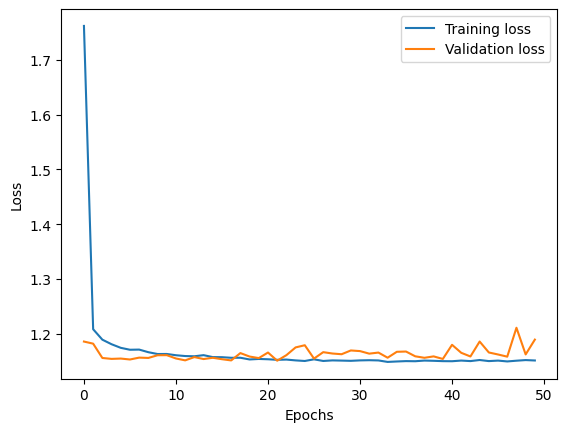

In [21]:
# Load the history
with open("model_history.json", "r") as f:
    saved_history = json.load(f)

# For example, plot the training and validation accuracy
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(saved_history['loss'], label='Training loss')
plt.plot(saved_history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [22]:
import ipywidgets as widgets
from IPython.display import display
import numpy as np
import pandas as pd
import tensorflow as tf

# Define input widgets
heart_disease_input = widgets.RadioButtons(options=['Yes', 'No'], description="Heart Disease:")
bmi_input = widgets.FloatText(description="BMI:")
smoking_input = widgets.RadioButtons(options=['Yes', 'No'], description="Smoking:")
alcohol_drinking_input = widgets.RadioButtons(options=['Yes', 'No'], description="Alcohol Drinking:")
stroke_input = widgets.RadioButtons(options=['Yes', 'No'], description="Stroke:")
physical_health_input = widgets.FloatText(description="Physical Health:")
mental_health_input = widgets.FloatText(description="Mental Health:")
diff_walking_input = widgets.RadioButtons(options=['Yes', 'No'], description="Difficulty Walking:")
sex_input = widgets.RadioButtons(options=['Male', 'Female'], description="Sex:")
age_category_input = widgets.Dropdown(options=["25-29", "30-34", "55-59", "80 or older"], description="Age Category:")
race_input = widgets.Dropdown(options=["White", "Hispanic", "Black", "Asian"], description="Race:")
diabetic_input = widgets.RadioButtons(options=['Yes', 'No'], description="Diabetic:")
physical_activity_input = widgets.RadioButtons(options=['Yes', 'No'], description="Physical Activity:")
gen_health_input = widgets.Dropdown(options=["Excellent", "Very good", "Fair", "Poor"], description="Gen Health:")
sleep_time_input = widgets.FloatText(description="Sleep Time:")
asthma_input = widgets.RadioButtons(options=['Yes', 'No'], description="Asthma:")
kidney_disease_input = widgets.RadioButtons(options=['Yes', 'No'], description="Kidney Disease:")
skin_cancer_input = widgets.RadioButtons(options=['Yes', 'No'], description="Skin Cancer:")
ecg_classification_input = widgets.Dropdown(options=['Myocardial Infarction', 'History of Myocardial Infarction', 'Normal Heartbeat', 'Abnormal Heartbeat'], description="ECG Classification:")


In [23]:
def predict():
    # Gather input values
    input_data = {
        'HeartDisease': heart_disease_input.value,
        'BMI': bmi_input.value,
        'Smoking': smoking_input.value,
        'AlcoholDrinking': alcohol_drinking_input.value,
        'Stroke': stroke_input.value,
        'PhysicalHealth': physical_health_input.value,
        'MentalHealth': mental_health_input.value,
        'DiffWalking': diff_walking_input.value,
        'Sex': sex_input.value,
        'AgeCategory': age_category_input.value,
        'Race': race_input.value,
        'Diabetic': diabetic_input.value,
        'PhysicalActivity': physical_activity_input.value,
        'GenHealth': gen_health_input.value,
        'SleepTime': sleep_time_input.value,
        'Asthma': asthma_input.value,
        'KidneyDisease': kidney_disease_input.value,
        'SkinCancer': skin_cancer_input.value,
        'ECG_Classification': ecg_classification_input.value
    }

    # Convert to DataFrame
    input_df = pd.DataFrame([input_data])

    # Preprocess Categorical Features
    # Assuming all_categorical_cols and label_encoders are defined elsewhere
    for col in all_categorical_cols:
        if col in input_df.columns and col in label_encoders:
            input_df[col] = label_encoders[col].transform(input_df[col])

    # Ensure input_df has the same columns as X_train used during training
    input_df = input_df[X_train.columns] #Added this line. X_train must be in scope of the predict function
    # Make predictions
    diagnosis, recommendation, critical_alert, followup, referral = model.predict(input_df)

    # Display predictions (using inverse_transform)
    print(f"Diagnosis: {label_encoders['Diagnosis'].inverse_transform(diagnosis.argmax(axis=1))}")
    print(f"Recommendation: {label_encoders['Recommendation'].inverse_transform(recommendation.argmax(axis=1))}")
    print(f"Critical Alert: {label_encoders['CriticalAlert'].inverse_transform(critical_alert.argmax(axis=1))}")
    print(f"Follow-Up: {label_encoders['FollowUp'].inverse_transform(followup.argmax(axis=1))}")
    print(f"Referral: {label_encoders['Referral'].inverse_transform(referral.argmax(axis=1))}")
# Display the input widgets
display(
    heart_disease_input, bmi_input, smoking_input, alcohol_drinking_input,
    stroke_input, physical_health_input, mental_health_input, diff_walking_input,
    sex_input, age_category_input, race_input, diabetic_input, physical_activity_input,
    gen_health_input, sleep_time_input, asthma_input, kidney_disease_input, skin_cancer_input, ecg_classification_input
)

# Create and display the prediction button
predict_button = widgets.Button(description="Predict")
predict_button.on_click(lambda x: predict())
display(predict_button)


RadioButtons(description='Heart Disease:', options=('Yes', 'No'), value='Yes')

FloatText(value=0.0, description='BMI:')

RadioButtons(description='Smoking:', options=('Yes', 'No'), value='Yes')

RadioButtons(description='Alcohol Drinking:', options=('Yes', 'No'), value='Yes')

RadioButtons(description='Stroke:', options=('Yes', 'No'), value='Yes')

FloatText(value=0.0, description='Physical Health:')

FloatText(value=0.0, description='Mental Health:')

RadioButtons(description='Difficulty Walking:', options=('Yes', 'No'), value='Yes')

RadioButtons(description='Sex:', options=('Male', 'Female'), value='Male')

Dropdown(description='Age Category:', options=('25-29', '30-34', '55-59', '80 or older'), value='25-29')

Dropdown(description='Race:', options=('White', 'Hispanic', 'Black', 'Asian'), value='White')

RadioButtons(description='Diabetic:', options=('Yes', 'No'), value='Yes')

RadioButtons(description='Physical Activity:', options=('Yes', 'No'), value='Yes')

Dropdown(description='Gen Health:', options=('Excellent', 'Very good', 'Fair', 'Poor'), value='Excellent')

FloatText(value=0.0, description='Sleep Time:')

RadioButtons(description='Asthma:', options=('Yes', 'No'), value='Yes')

RadioButtons(description='Kidney Disease:', options=('Yes', 'No'), value='Yes')

RadioButtons(description='Skin Cancer:', options=('Yes', 'No'), value='Yes')

Dropdown(description='ECG Classification:', options=('Myocardial Infarction', 'History of Myocardial Infarctio…

Button(description='Predict', style=ButtonStyle())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Diagnosis: ['Minor Arrhythmia; No Immediate Concern']
Recommendation: ['Lifestyle modifications; reduce caffeine and stress.']
Critical Alert: ['Low']
Follow-Up: ['3-month follow-up if symptoms develop.']
Referral: ['No']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Diagnosis: ['Minor Arrhythmia; No Immediate Concern']
Recommendation: ['Lifestyle modifications; reduce caffeine and stress.']
Critical Alert: ['Low']
Follow-Up: ['3-month follow-up if symptoms develop.']
Referral: ['No']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Diagnosis: ['Minor Arrhythmia; No Immediate Concern']
Recommendation: ['Lifestyle modifications; reduce caffeine and stress.']
Critical Alert: ['Low']
Follow-Up: ['3-month follow-up if symptoms develop.']
Referral: ['No']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Diagnosis: ['Minor Arrhythmia; No Immediate Concern']
Recommendation: ['Lifestyle modifications; reduce caffeine and stress.']
Critical Alert: ['Low']
Follow-Up: ['3-month follow-up 

Saving preprocessing steps for deployment

In [24]:
# Import necessary libraries
import json
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import joblib

# Define columns based on feature type
col_binary = ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex', 'Diabetic',
              'Diagnosis', 'PhysicalActivity', 'Asthma', 'KidneyDisease', 'SkinCancer', 'HeartDisease']
col_categorical = ['AgeCategory', 'Race', 'GenHealth', 'ECG_Classification',
                   'Recommendation', 'FollowUp', 'Referral', 'CriticalAlert']
col_continuous = ['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']

# Combine all categorical columns (binary and categorical)
all_categorical_cols = col_binary + col_categorical

# Initialize Label Encoders for Categorical Columns
label_encoders = {}
for col in all_categorical_cols:
    le = LabelEncoder()
    # Encode training set
    if col in new_data.columns:
        new_data[col] = le.fit_transform(new_data[col].astype(str))
    else:
        print(f"Column '{col}' not found in new_data DataFrame")

    # Save the encoder for each column
    label_encoders[col] = le
    joblib.dump(le, f'label_encoder_{col}.pkl')  # Save each Label Encoder

# Standardize Continuous Columns
scaler = StandardScaler()
new_data[col_continuous] = scaler.fit_transform(new_data[col_continuous])

# Save the scaler
joblib.dump(scaler, 'standard_scaler.pkl')

# Prepare the Features (X) and Targets (y)
X = new_data[['BMI', 'Smoking', 'AlcoholDrinking', 'Stroke', 'PhysicalHealth',
              'MentalHealth', 'DiffWalking', 'Sex', 'AgeCategory', 'Race', 'Diabetic',
              'PhysicalActivity', 'GenHealth', 'SleepTime', 'Asthma', 'KidneyDisease',
              'SkinCancer', 'ECG_Classification']]

# Separate each target variable for prediction
y_diagnosis = new_data['Diagnosis']
y_recommendation = new_data['Recommendation']
y_critical_alert = new_data['CriticalAlert']
y_follow_up = new_data['FollowUp']
y_referral = new_data['Referral']
y_heart_disease = new_data['HeartDisease']

# Convert categorical columns in X to numerical using one-hot encoding
X = pd.get_dummies(X)


In [25]:
import joblib

# Dictionary to store all label encoders
label_encoders = {}

# Fit and save label encoders for categorical columns
for col in all_categorical_cols:
    le = LabelEncoder()
    if col in new_data.columns:
        new_data[col] = le.fit_transform(new_data[col].astype(str))
    else:
        print(f"Column '{col}' not found in new_data DataFrame")
    # Store the fitted encoder in the dictionary
    label_encoders[col] = le

# Save the dictionary with all label encoders
joblib.dump(label_encoders, 'label_encoders.pkl')

# Save the scaler separately
scaler = StandardScaler()
new_data[col_continuous] = scaler.fit_transform(new_data[col_continuous])
joblib.dump(scaler, 'standard_scaler.pkl')


['standard_scaler.pkl']